In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = xr.open_dataset(r"C:\US-Baltimore_clean_observations_v1.nc", engine='netcdf4') 
data = dataset.sel(time=slice('2003-01-01', '2006-12-31'))
print(f"Временной диапазон: {data.time.min().values} → {data.time.max().values}")
print(f"Размер: {data.dims['time']} записей")
print(f"Всего переменных: {len(data.data_vars)}")

Временной диапазон: 2003-01-01T00:00:00.000000000 → 2006-12-31T23:00:00.000000000
Размер: 35064 записей
Всего переменных: 30


In [4]:
targets = ['Qh', 'Qle', 'Qtau']
all_vars = list(data.data_vars)
predictors = [v for v in all_vars if '_qc' not in v and v not in targets]
print(f"Цели: {targets}")
print(f"Предикторы ({len(predictors)}): {predictors}")

Цели: ['Qh', 'Qle', 'Qtau']
Предикторы (12): ['SWdown', 'LWdown', 'Tair', 'Qair', 'PSurf', 'Rainf', 'Snowf', 'Wind_N', 'Wind_E', 'SWup', 'LWup', 'SoilTemp']


In [ ]:
df = data[predictors + targets].to_dataframe()
df.index = pd.to_datetime(df.index) 
df = df.sort_index()
print(f"\nИсходный размер: {len(df)} строк")
print("Пропуски до обработки:\n", df.isna().sum())


Исходный размер: 35064 строк
Пропуски до обработки:
 SWdown       3464
LWdown       3164
Tair          244
Qair         3348
PSurf        2318
Rainf         754
Snowf       35064
Wind_N       5119
Wind_E       5119
SWup        17442
LWup         3164
SoilTemp       37
Qh          10751
Qle         19549
Qtau         5253
dtype: int64


In [6]:
df[predictors] = df[predictors].interpolate(method='time', limit_direction='both')
df[predictors] = df[predictors].fillna(df[predictors].mean())
df['Snowf'] = df['Snowf'].fillna(0)  # вместо interpolate для Snowf
print("\nПропуски после интерполяции в предикторах:\n", df[predictors].isna().sum())
print("Пропуски в целях (оставлены для предсказания):\n", df[targets].isna().sum())


Пропуски после интерполяции в предикторах:
 SWdown      0
LWdown      0
Tair        0
Qair        0
PSurf       0
Rainf       0
Snowf       0
Wind_N      0
Wind_E      0
SWup        0
LWup        0
SoilTemp    0
dtype: int64
Пропуски в целях (оставлены для предсказания):
 Qh      10751
Qle     19549
Qtau     5253
dtype: int64


In [ ]:
original_predictors = predictors.copy()  # ← КОПИЯ исходных
print(f"LinearRegression: использует {len(original_predictors)} исходных предикторов")

# Только для Ridge
df['U'] = np.sqrt(df['Wind_N']**2 + df['Wind_E']**2)
df['hour'] = df.index.hour
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_month'] = np.sin(2 * np.pi * df.index.month / 12)

# Новый список предикторов для Ridge
predictors_ridge = original_predictors + ['U', 'sin_hour', 'cos_hour', 'sin_month']
print(f"Ridge: использует {len(predictors_ridge)} предикторов (добавлено 4)")

LinearRegression: использует 12 исходных предикторов
Ridge: использует 16 предикторов (добавлено 4)


In [ ]:
models_lr = {}
models_ridge = {}
results_lr = {}
results_ridge = {}

for target in targets:
    print(f"\n\n{'='*70}")
    print(f"ОБУЧЕНИЕ ДЛЯ {target}")
    print(f"{'='*70}")
    
    df_train = df.dropna(subset=[target])
    
    # только исходные предикторы ---
    X_lr = df_train[original_predictors]
    y = df_train[target]
    
    if len(df_train) < 100:
        print(f"Мало данных для {target}")
        continue
    
    X_train_lr, X_test_lr, y_train_lr, y_test = train_test_split(
        X_lr, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    model_lr = LinearRegression()
    model_lr.fit(X_train_lr, y_train_lr)
    models_lr[target] = model_lr
    
    y_pred_lr = model_lr.predict(X_test_lr)
    results_lr[target] = {
        'R2': r2_score(y_test, y_pred_lr),
        'MSE': mean_squared_error(y_test, y_pred_lr)
    }
    
    # расширенные предикторы ---
    X_ridge = df_train[predictors_ridge]
    X_train_ridge, X_test_ridge, y_train_ridge, _ = train_test_split(
        X_ridge, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    model_ridge = Ridge(alpha=0.1)
    model_ridge.fit(X_train_ridge, y_train_ridge)
    models_ridge[target] = model_ridge
    
    y_pred_ridge = model_ridge.predict(X_test_ridge)
    results_ridge[target] = {
        'R2': r2_score(y_test, y_pred_ridge),
        'MSE': mean_squared_error(y_test, y_pred_ridge)
    }
    
    print(f"LinearRegression (исходные) → R²: {results_lr[target]['R2']:.4f} | MSE: {results_lr[target]['MSE']:.4f}")
    print(f"Ridge (расширенные)         → R²: {results_ridge[target]['R2']:.4f} | MSE: {results_ridge[target]['MSE']:.4f}")



ОБУЧЕНИЕ ДЛЯ Qh
LinearRegression (исходные) → R²: 0.7946 | MSE: 1621.9686
Ridge (расширенные)         → R²: 0.7947 | MSE: 1621.0750


ОБУЧЕНИЕ ДЛЯ Qle
LinearRegression (исходные) → R²: 0.7131 | MSE: 2023.9410
Ridge (расширенные)         → R²: 0.7222 | MSE: 1959.4016


ОБУЧЕНИЕ ДЛЯ Qtau
LinearRegression (исходные) → R²: 0.2236 | MSE: 0.0515
Ridge (расширенные)         → R²: 0.6757 | MSE: 0.0215


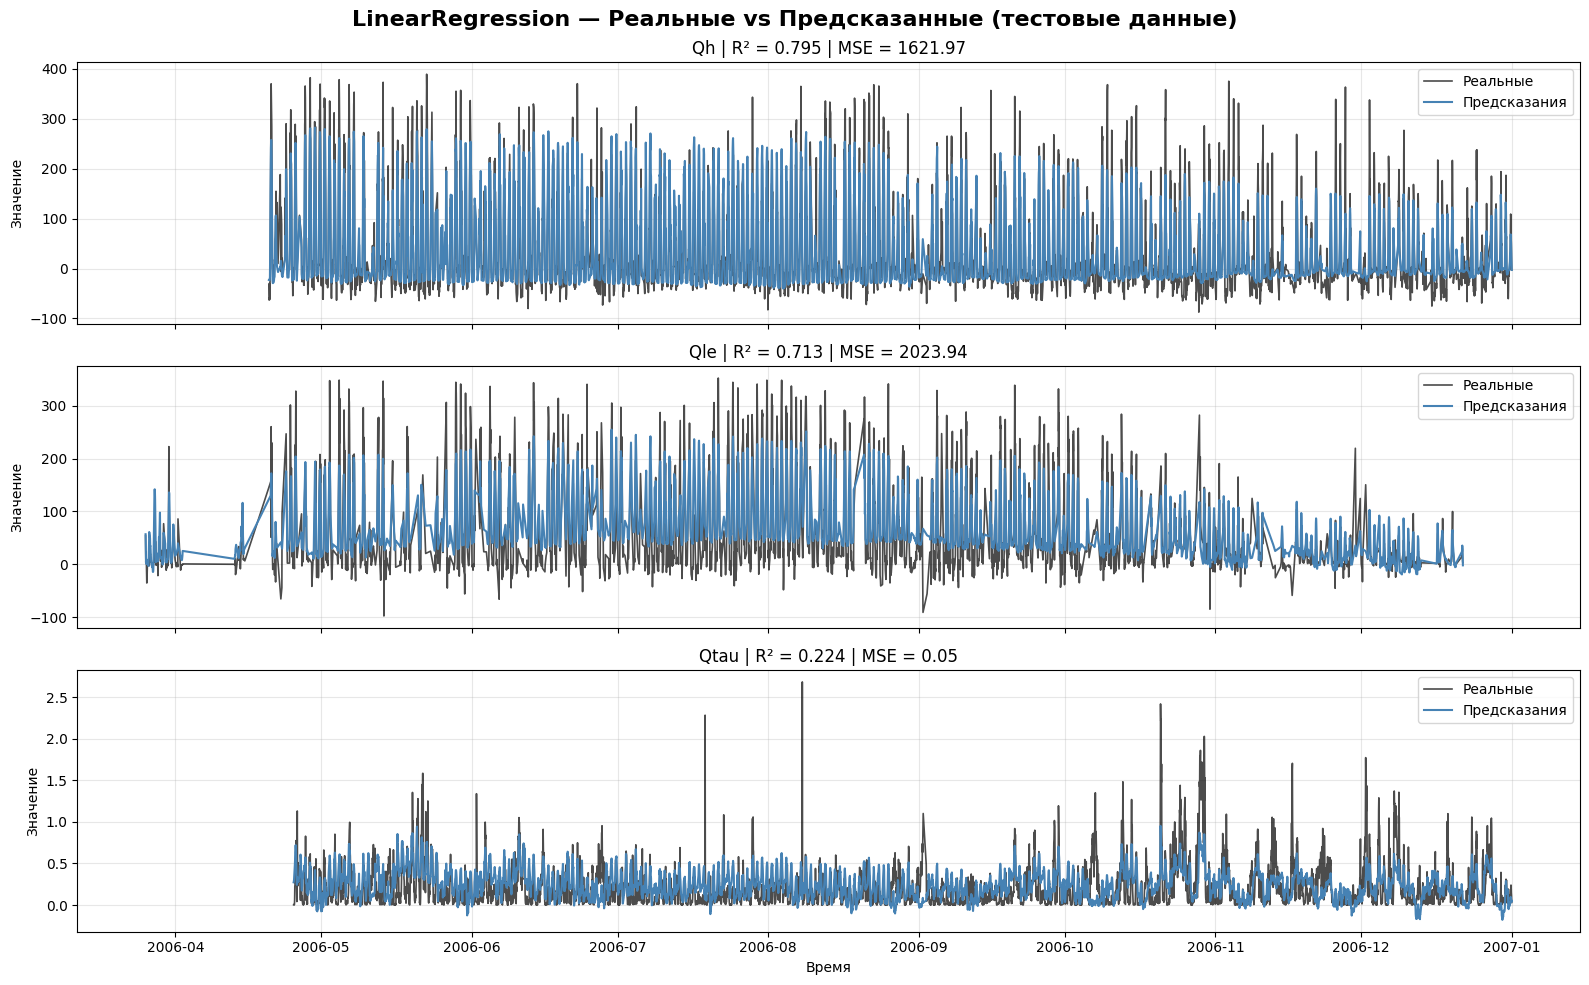

In [18]:
#LinearRegression
fig1, axes1 = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
fig1.suptitle('LinearRegression — Реальные vs Предсказанные (тестовые данные)', 
              fontsize=16, fontweight='bold', y=0.98)

for idx, target in enumerate(targets):
    if target not in models_lr:
        continue
    
    df_train = df.dropna(subset=[target])
    X_lr = df_train[original_predictors]  # только исходные
    y = df_train[target]
    
    _, X_test_lr, _, y_test = train_test_split(
        X_lr, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models_lr[target].predict(X_test_lr)
    times = X_test_lr.index

    ax = axes1[idx]
    ax.plot(times, y_test, label='Реальные', color='black', linewidth=1.2, alpha=0.7)
    ax.plot(times, y_pred, label='Предсказания', color='steelblue', linewidth=1.5)
    
    r2 = results_lr[target]['R2']
    mse = results_lr[target]['MSE']
    ax.set_title(f'{target} | R² = {r2:.3f} | MSE = {mse:.2f}', fontsize=12)
    ax.set_ylabel('Значение')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes1[-1].set_xlabel('Время')
plt.tight_layout()
plt.show()

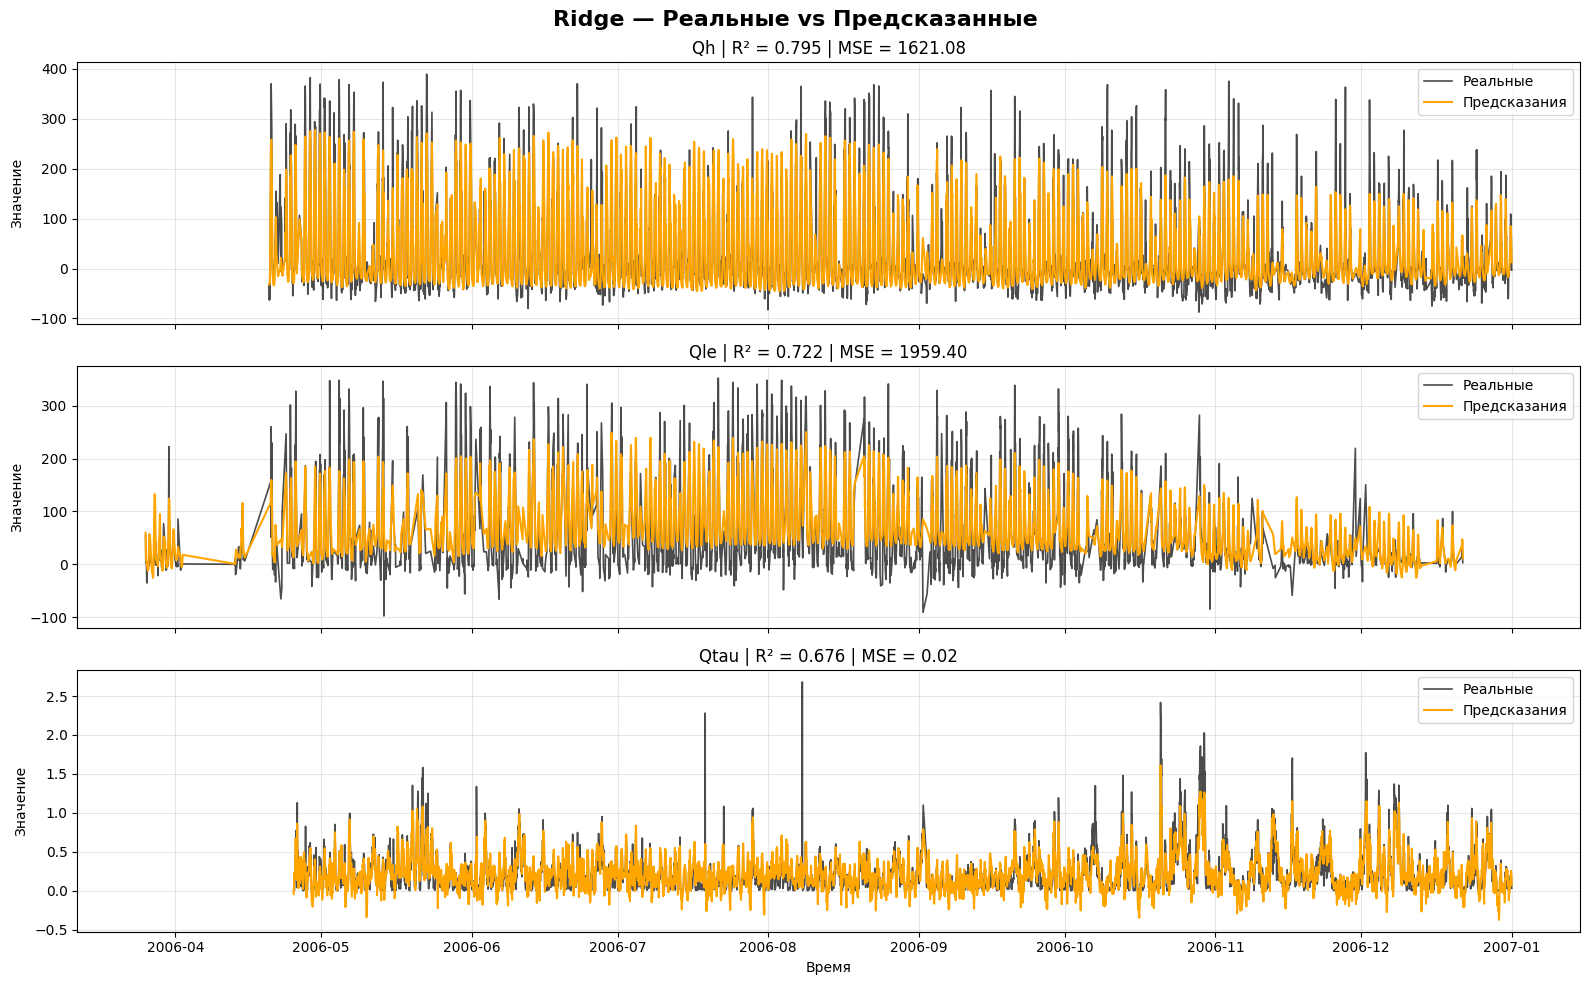

In [17]:
#Ridge
fig2, axes2 = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
fig2.suptitle('Ridge — Реальные vs Предсказанные', fontsize=16, fontweight='bold')

for idx, target in enumerate(targets):
    if target not in models_ridge:
        continue
    
    df_train = df.dropna(subset=[target])
    X_ridge = df_train[predictors_ridge]  # ← расширенные
    y = df_train[target]
    
    # ИСПРАВЛЕНО: X_ridge, а не "X Hao_ridge"
    _, X_test_ridge, _, y_test = train_test_split(
        X_ridge, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models_ridge[target].predict(X_test_ridge)
    times = X_test_ridge.index

    ax = axes2[idx]
    ax.plot(times, y_test, label='Реальные', color='black', linewidth=1.2, alpha=0.7)
    ax.plot(times, y_pred, label='Предсказания', color='orange', linewidth=1.5)
    
    r2 = results_ridge[target]['R2']
    mse = results_ridge[target]['MSE']
    ax.set_title(f'{target} | R² = {r2:.3f} | MSE = {mse:.2f}')
    ax.set_ylabel('Значение')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes2[-1].set_xlabel('Время')
plt.tight_layout()
plt.show()

In [24]:
print(f"Qtau: среднее = {df['Qtau'].mean():.3f}, std = {df['Qtau'].std():.3f}")

Qtau: среднее = 0.244, std = 0.299


In [ ]:
print(f"\n\n{'*'*70}")
print("СОХРАНЕНИЕ В NETCDF")
print(f"{'*'*70}")

import os

# Путь к файлу
output_path = r"C:\US-Baltimore_filled_with_predictions.nc"

# Удаляем старый файл, если есть (чтобы не было ошибки)
if os.path.exists(output_path):
    try:
        os.remove(output_path)
        print(f"Старый файл удалён: {output_path}")
    except:
        print(f"Не удалось удалить файл. Закройте все программы, где он открыт!")
        raise

# Создаём xarray Dataset из DataFrame
ds_out = df.to_xarray()

# Добавляем атрибуты
ds_out.attrs['title'] = 'Baltimore flux data: original + gap-filled (Ridge regression)'
ds_out.attrs['created_on'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')
ds_out.attrs['method'] = 'Multiple linear regression (Ridge α=0.1) with time interpolation'
ds_out.attrs['targets_filled'] = 'Qh, Qle, Qtau'
ds_out.attrs['predictors'] = ', '.join(predictors)

# Сохраняем
try:
    ds_out.to_netcdf(output_path, engine='netcdf4')
    print(f"УСПЕШНО СОХРАНЕНО: {output_path}")
    print(f"   • Строк: {len(df)}")
    print(f"   • Переменных: {len(ds_out.data_vars)}")
    print(f"   • Заполнено пропусков:")
    for target in targets:
        if target + '_pred_ridge' in df.columns:
            filled = df[target + '_pred_ridge'].notna().sum()
            print(f"     - {target}: {filled} значений")
except Exception as e:
    print(f"ОШИБКА ПРИ СОХРАНЕНИИ: {e}")
    print("   → Закройте Panoply, Excel, Python — и попробуйте снова.")




**********************************************************************
СОХРАНЕНИЕ В NETCDF
**********************************************************************
ОШИБКА ПРИ СОХРАНЕНИИ: [Errno 13] Permission denied: 'C:\\US-Baltimore_filled_with_predictions.nc'
   → Закройте Panoply, Excel, Python — и попробуйте снова.
